In [47]:
# ROLLING CROSS VALIDATION

In [48]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [49]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

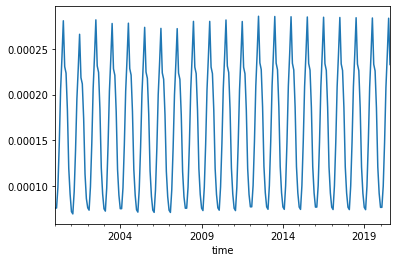

In [50]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [51]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# TODO Passare come ts la serie senza il 2020 giusto?
def rolling_cross_validation(ts, order, seasonal_order, initial_train_months=36, verbose=False):

    aics = []
    bics = []
    rmses = []

    train_months = initial_train_months # Mesi di training allo step iniziale
    n = len(ts)

    while train_months < (n-12):
        train_data = ts[0:train_months]
        validation_data = ts[train_months:train_months+12] # Validazione fissa ai 12 mesi successivi

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit() # TODO Lore qui avevi tolto seasonal_order=seasonal_order, c'era un motivo?

        aics.append(model.aic)
        bics.append(model.bic)

        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        train_months += 12 # Incrementare i mesi di training
    
    return np.mean(rmses), np.mean(aics), np.mean(bics)

In [53]:
import numpy as np

def model_selection(ts, initial_train_months=36, verbose=False):
    p_list = [1, 2, 3]
    q_list = [0, 1, 2]
    P_list = [0, 1, 2]
    Q_list = [0, 1]
    s = 12

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    
                    model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={}'.format(p, q, P, Q, s)
                    model_idx = idx

                    if verbose: print('{}: {}'.format(model_idx, model_name))
                    
                    rmse, aic, bic = rolling_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), initial_train_months=initial_train_months)

                    results[model_name] = {
                        'order' : (p,0,q),
                        'seasonal_order' : (P,0,Q,s),
                        'aic' : aic,
                        'bic' : bic,
                        'rmse' : rmse,
                        'index' : model_idx            
                        }

                    idx += 1
    return results

In [54]:
results = model_selection(nh3, initial_train_months=36, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12
1: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=1, s=12
2: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12
3: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12
4: SARIMA(p=1, d=0, q=0, P=2, D=0, Q=0, s=12
5: SARIMA(p=1, d=0, q=0, P=2, D=0, Q=1, s=12
6: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=12
7: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=1, s=12
8: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12
9: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12
10: SARIMA(p=1, d=0, q=1, P=2, D=0, Q=0, s=12
11: SARIMA(p=1, d=0, q=1, P=2, D=0, Q=1, s=12
12: SARIMA(p=1, d=0, q=2, P=0, D=0, Q=0, s=12
13: SARIMA(p=1, d=0, q=2, P=0, D=0, Q=1, s=12
14: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12
15: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12
16: SARIMA(p=1, d=0, q=2, P=2, D=0, Q=0, s=12
17: SARIMA(p=1, d=0, q=2, P=2, D=0, Q=1, s=12
18: SARIMA(p=2, d=0, q=0, P=0, D=0, Q=0, s=12
19: SARIMA(p=2, d=0, q=0, P=0, D=0, Q=1, s=12
20: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=0, s=12
21: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=1, s=1

In [55]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]

In [56]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

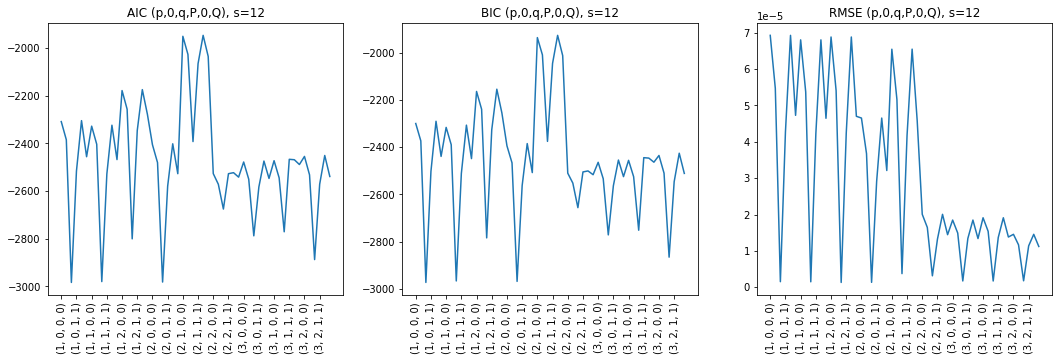

In [57]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 3)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [58]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 2, min BIC 2, min RMSE 14


In [59]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (1, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2983.797724258262,
 'bic': -2972.764747775195,
 'rmse': 1.538536592740279e-06,
 'index': 2}

In [60]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': (1, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2983.797724258262,
 'bic': -2972.764747775195,
 'rmse': 1.538536592740279e-06,
 'index': 2}

In [61]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (1, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2800.733943467476,
 'bic': -2784.1844787428745,
 'rmse': 1.3322506117604471e-06,
 'index': 14}